### Soca Road March Analysis with RNN and Kappa Regression

In [ ]:
### SECTION 0 - Libraries

import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import numpy as np
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter
from nltk import FreqDist
from nltk.tokenize import word_tokenize
from collections import Counter
import networkx as nx

# Ensure required NLTK resources are downloaded
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# Load the historical soca song data
historical_df = pd.read_excel("/content/soca_songs_2004_2024(1).xlsx")

# Load the new 2025 soca song data
new_songs_df = pd.read_excel("/content/new_songs_2025(1).xlsx")

In [ ]:
# Preview the first few rows and column names
print(historical_df.head())
print(historical_df.columns)


   Year             Performer               Song  \
0  2024            Mical Teja                DNA   
1  2024          Bunji Garlin  Carnival Contract   
2  2024          Nadia Batson             Market   
3  2023          Bunji Garlin          Hard Fete   
4  2023  Shaggy featuring Kes               Mood   

                                              Lyrics Winner  Tempo  Key  Mode  
0  When we outside is a ocean of love\nAll of we ...    Yes  140.0    2     1  
1  Me and carnival have a contract\nEvery year we...     No  133.6   11     0  
2  If yuh lookin for sweetness to put inside a ba...     No  141.5    7     0  
3  Best lit entry of the century\nOoh\nBragga, oo...    Yes  150.2    5     1  
4  [Intro]\nI in the mood right now (Seh wi ready...     No  132.7   10     1  
Index(['Year', 'Performer', 'Song', 'Lyrics', 'Winner', 'Tempo', 'Key',
       'Mode'],
      dtype='object')


In [ ]:
# Convert Winner column to binary (if not already)
historical_df["Winner"] = historical_df["Winner"].apply(lambda x: 1 if x =="Yes" else 0)

# Split into winners and non-winners
df_win = historical_df[historical_df["Winner"] == 1].reset_index(drop=True)
df_con = historical_df[historical_df["Winner"] == 0].reset_index(drop=True)

**Exploratory Data Analysis**

In [ ]:
### MOST COMMON WORD OF WINNERS
# Combine all lyrics for analysis
all_lyrics_win = " ".join(df_win["Lyrics"].dropna()).lower()

# Remove stopwords and tokenize
stop_words = set(stopwords.words("english"))
tokens_win = nltk.word_tokenize(all_lyrics_win)
filtered_tokens_win = [word for word in tokens_win if word.isalnum() and word not in stop_words]

# Word Frequency Analysis
word_freq = Counter(filtered_tokens_win)
print("Most Common Words:", word_freq.most_common(10))

Most Common Words: [('yuh', 217), ('jump', 183), ('de', 139), ('ah', 122), ('start', 105), ('jumping', 102), ('stage', 88), ('doh', 87), ('pump', 79), ('show', 77)]


In [ ]:
### MOST COMMON WORD OF NON-WINNERS
# Combine all lyrics for analysis
all_lyrics_con = " ".join(df_con["Lyrics"].dropna()).lower()

# Remove stopwords and tokenize
stop_words = set(stopwords.words("english"))
tokens_con = nltk.word_tokenize(all_lyrics_con)
filtered_tokens_con = [word for word in tokens_con if word.isalnum() and word not in stop_words]

# Word Frequency Analysis
word_freq = Counter(filtered_tokens_con)
print("Most Common Words:", word_freq.most_common(10))

Most Common Words: [('ah', 316), ('oh', 202), ('meh', 169), ('de', 160), ('yuh', 121), ('say', 121), ('yay', 117), ('come', 111), ('na', 109), ('ready', 108)]


In [ ]:
df_win.head()

,Year,Performer,Song,Lyrics,Winner,Tempo,Key,Mode
0,2024,Mical Teja,DNA,When we outside is a ocean of love\nAll of we ...,1,140.0,2,1
1,2023,Bunji Garlin,Hard Fete,"Best lit entry of the century\nOoh\nBragga, oo...",1,150.2,5,1
2,2021,Farmer Nappy,Backyard Jam,Brrrrrrrrng diggy diggy diggy diggy diggy\nAll...,1,140.4,2,1
3,2020,"Neil ""Iwer"" George & Kes Dieffenthaller",Stage Gone Bad,Bad\nBad\nBad\nBad\nStage gone bad\n(Kes)\nBad...,1,130.3,4,0
4,2019,"Machel Montano, Skinny Fabulous & Bunji Garlin",Famalay,"[Intro: Bunji Garlin, Machel Montano & Skinny ...",1,117.8,6,0


In [ ]:
df_con.head()

,Year,Performer,Song,Lyrics,Winner,Tempo,Key,Mode
0,2024,Bunji Garlin,Carnival Contract,Me and carnival have a contract\nEvery year we...,0,133.6,11,0
1,2024,Nadia Batson,Market,If yuh lookin for sweetness to put inside a ba...,0,141.5,7,0
2,2023,Shaggy featuring Kes,Mood,[Intro]\nI in the mood right now (Seh wi ready...,0,132.7,10,1
3,2023,Shaggy featuring Patrice Roberts,Whine & Jumping,We Pon Dis Streets\nWe Whine And Jumping\nThe ...,0,132.7,2,1
4,2022,Voice & V'ghn,Trinidad Sweet,Just take ah shot when yuh see me dawg\nI want...,0,150.8,0,1


In [ ]:
# Topic Modeling with LDA

def perform_topic_modeling(lyrics, n_topics=3):
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    lyrics_matrix = vectorizer.fit_transform(lyrics)

    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(lyrics_matrix)

    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda.components_):
        topic_words = [feature_names[i] for i in topic.argsort()[:-11:-1]]
        topics.append(f"Topic {topic_idx + 1}: {' '.join(topic_words)}")
    return topics

In [ ]:
 #for WINNERS


# Filter out nulls and enforce string type for LDA input
clean_lyrics_win = df_win["Lyrics"].dropna()
clean_lyrics_win = clean_lyrics_win[clean_lyrics_win.apply(lambda x: isinstance(x, str) and x.strip() != "")]

# Run topic modeling
topics_win = perform_topic_modeling(clean_lyrics_win, n_topics=2)

# Display topics
print("Identified Topics for Winners:")
for topic in topics_win:
    print(topic)


Identified Topics for Winners:
Topic 1: yuh hold jumping lay doh pump work air dem eh
Topic 2: jump advantage ah wine stage fling bouncing bad palance home


In [ ]:
# Topic Modeling with LDA for NON-WINNERS


# Filter out nulls and enforce string type for LDA input
clean_lyrics_con = df_con["Lyrics"].dropna()
clean_lyrics_con = clean_lyrics_con[clean_lyrics_con.apply(lambda x: isinstance(x, str) and x.strip() != "")]

# Run topic modeling
topics_con = perform_topic_modeling(clean_lyrics_con, n_topics=2)

# Display topics
print("Identified Topics for Contenders:")
for topic in topics_con:
    print(topic)


Identified Topics for Contenders:
Topic 1: ready ah yay ola naa dey come jump low carry
Topic 2: ah oh meh di road bacchanal yuh yeah make people


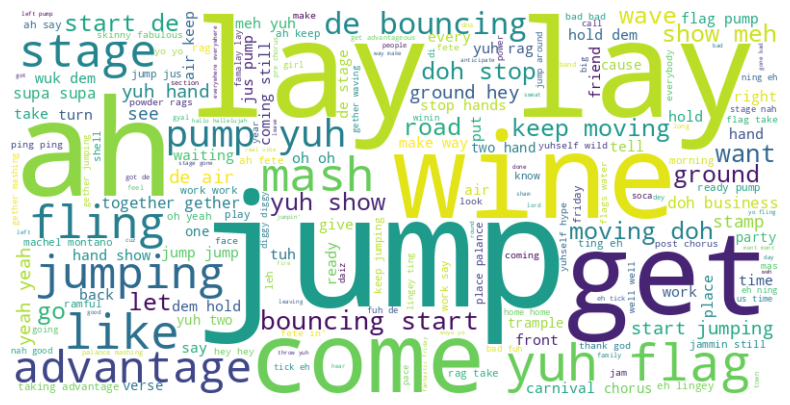

In [ ]:
# Generate a Word Cloud of winners
def generate_wordcloud(text):
    wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=800, height=400).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

generate_wordcloud(all_lyrics_win)


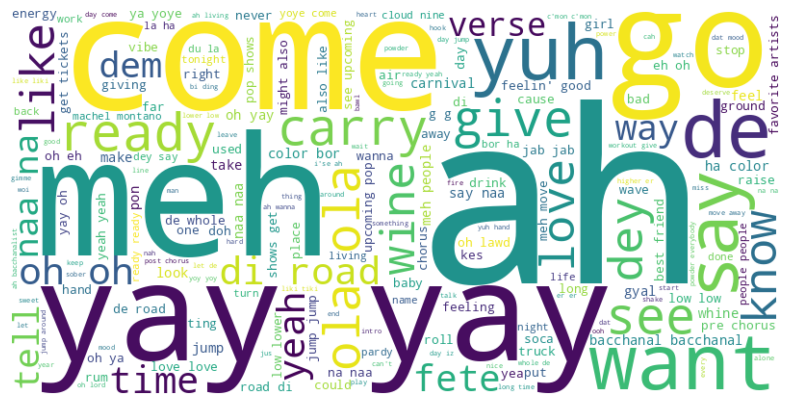

In [ ]:
generate_wordcloud(all_lyrics_con)

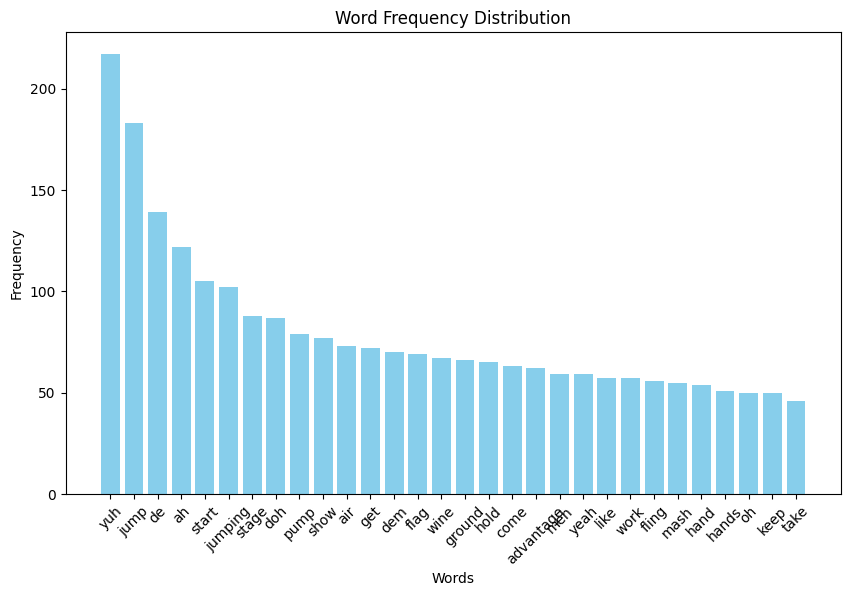

In [ ]:
# Word Frequency Distribution of WINNERS
def plot_word_frequency(tokens_win, top_n=30):
    freq_dist = FreqDist(tokens_win)
    most_common = freq_dist.most_common(top_n)

    # Plot
    words, counts = zip(*most_common)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="skyblue")
    plt.title("Word Frequency Distribution")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

plot_word_frequency(filtered_tokens_win)

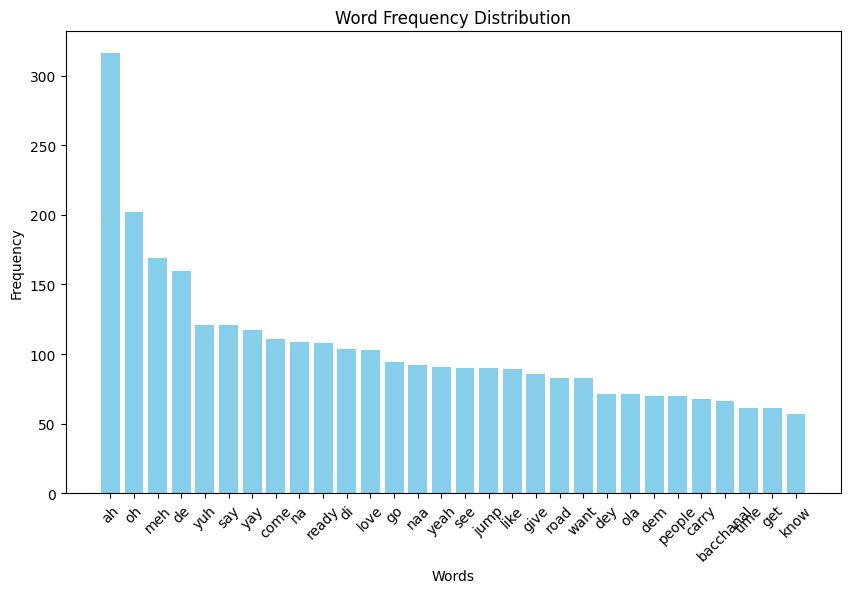

In [ ]:
# Word Frequency Distribution of NON-WINNERS
def plot_word_frequency(tokens_con, top_n=30):
    freq_dist = FreqDist(tokens_con)
    most_common_con = freq_dist.most_common(top_n)

    # Plot
    words, counts = zip(*most_common_con)
    plt.figure(figsize=(10, 6))
    plt.bar(words, counts, color="skyblue")
    plt.title("Word Frequency Distribution")
    plt.xlabel("Words")
    plt.ylabel("Frequency")
    plt.xticks(rotation=45)
    plt.show()

plot_word_frequency(filtered_tokens_con)

Generating co-occurrence pairs: 100%|██████████| 6055/6055 [00:00<00:00, 855533.46it/s]


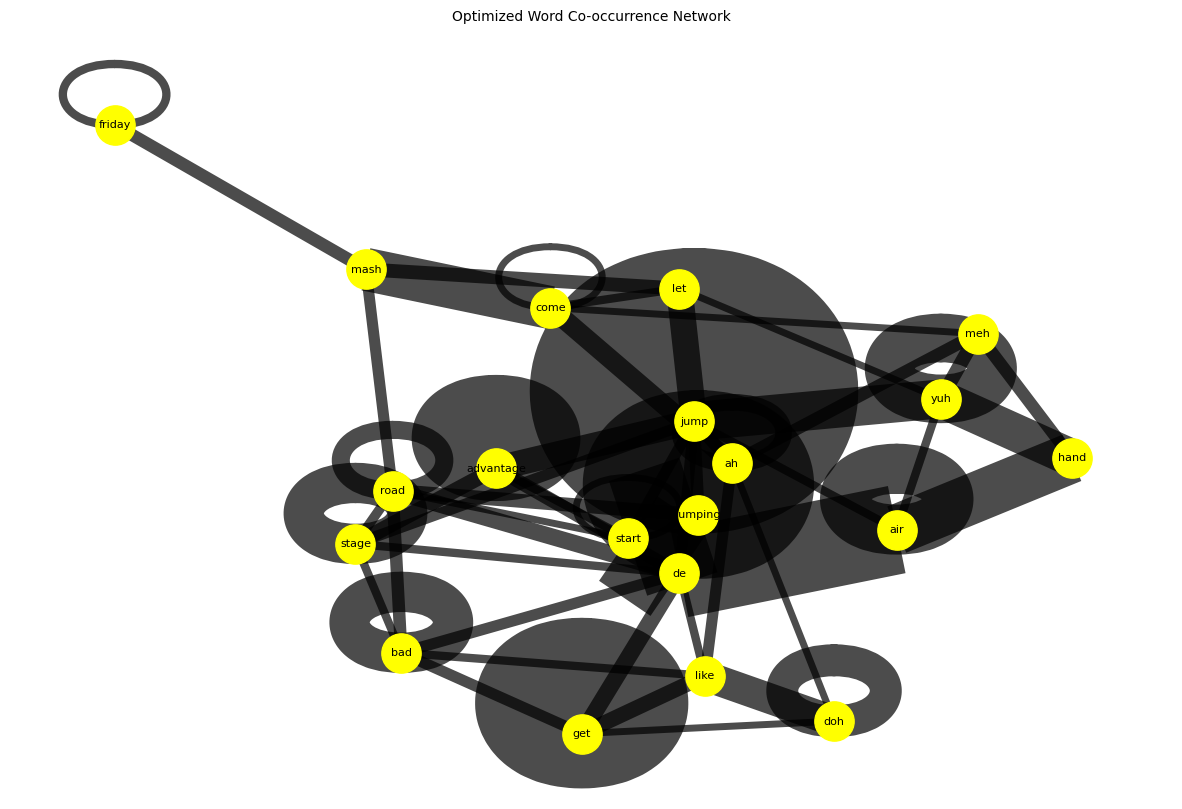

In [ ]:
def plot_word_relationships_optimized(tokens_win, window_size=2, min_count=2, max_nodes=50):
    """
    Optimized function to create a word co-occurrence network.
    - Adjusted node size, font size, edge width, and figure layout.
    """
    from itertools import combinations
    from tqdm import tqdm

    # Generate co-occurrence pairs with a sliding window
    co_occurrences_win = []
    for i in tqdm(range(len(tokens_win) - window_size + 1), desc="Generating co-occurrence pairs"):
        window = tokens_win[i:i + window_size]
        co_occurrences_win.extend(combinations(window, 2))

    # Count co-occurrence pairs
    co_occurrence_counts_win = Counter(co_occurrences_win)
    # Filter by minimum count
    co_occurrence_counts_win = {pair: count for pair, count in co_occurrence_counts_win.items() if count >= min_count}

    # Create graph
    G_win = nx.Graph()
    for (word1, word2), count in co_occurrence_counts_win.items():
        G_win.add_edge(word1, word2, weight=count)

    # Limit the graph size for visualization
    if len(G_win.nodes) > max_nodes:
        G_win = nx.subgraph(G_win, sorted(G_win.nodes, key=G_win.degree, reverse=True)[:max_nodes])

    # Adjust layout
    pos = nx.spring_layout(G_win, seed=42, k=1)  # k controls node spacing (higher = more spread)

    # Draw graph
    plt.figure(figsize=(15, 10))  # Larger figure for better clarity
    nx.draw_networkx_nodes(G_win, pos, node_size=800, node_color="yellow")  # Smaller nodes
    nx.draw_networkx_edges(G_win, pos, width=[G_win[u][v]['weight'] for u, v in G_win.edges()], alpha=0.7)  # Adjust edge width
    nx.draw_networkx_labels(G_win, pos, font_size=8, font_family="sans-serif")  # Smaller font size
    plt.title("Optimized Word Co-occurrence Network", fontsize=10)
    plt.axis("off")  # Remove axes for clarity
    plt.show()

# Example usage
#filtered_tokens = ["love", "fire", "heart", "love", "dark", "light", "fire", "love", "heart"] * 1000
plot_word_relationships_optimized(filtered_tokens_win, window_size=3, min_count=5, max_nodes=20)


Generating co-occurrence pairs: 100%|██████████| 9888/9888 [00:00<00:00, 784720.78it/s]


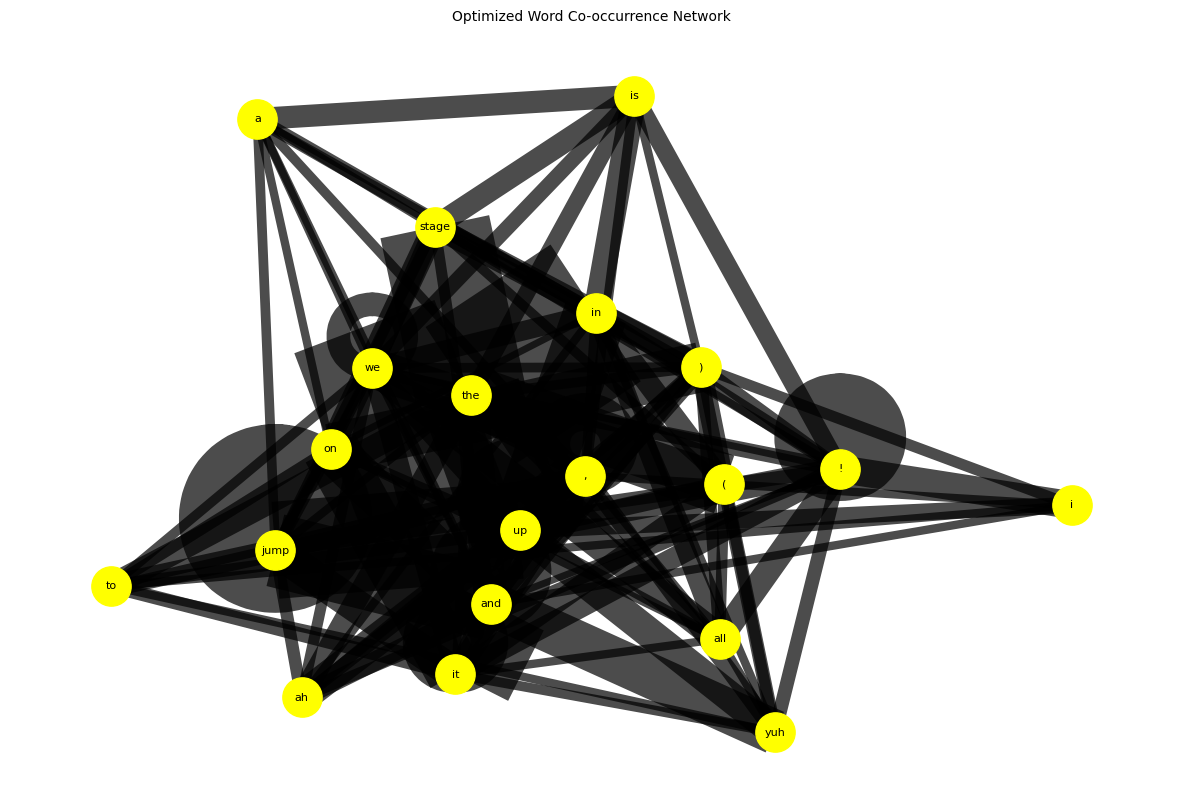

In [ ]:
def plot_word_relationships_optimized(tokens_con, window_size=2, min_count=2, max_nodes=50):
    """
    Optimized function to create a word co-occurrence network.
    - Adjusted node size, font size, edge width, and figure layout.
    """
    from itertools import combinations
    from tqdm import tqdm

    # Generate co-occurrence pairs with a sliding window
    co_occurrences_con = []
    for i in tqdm(range(len(tokens_con) - window_size + 1), desc="Generating co-occurrence pairs"):
        window = tokens_win[i:i + window_size]
        co_occurrences_con.extend(combinations(window, 2))

    # Count co-occurrence pairs
    co_occurrence_counts_con = Counter(co_occurrences_con)
    # Filter by minimum count
    co_occurrence_counts_con = {pair: count for pair, count in co_occurrence_counts_con.items() if count >= min_count}

    # Create graph
    G_con = nx.Graph()
    for (word1, word2), count in co_occurrence_counts_con.items():
        G_con.add_edge(word1, word2, weight=count)

    # Limit the graph size for visualization
    if len(G_con.nodes) > max_nodes:
        G_con = nx.subgraph(G_con, sorted(G_con.nodes, key=G_con.degree, reverse=True)[:max_nodes])

    # Adjust layout
    pos = nx.spring_layout(G_con, seed=42, k=1)  # k controls node spacing (higher = more spread)

    # Draw graph
    plt.figure(figsize=(15, 10))  # Larger figure for better clarity
    nx.draw_networkx_nodes(G_con, pos, node_size=800, node_color="yellow")  # Smaller nodes
    nx.draw_networkx_edges(G_con, pos, width=[G_con[u][v]['weight'] for u, v in G_con.edges()], alpha=0.7)  # Adjust edge width
    nx.draw_networkx_labels(G_con, pos, font_size=8, font_family="sans-serif")  # Smaller font size
    plt.title("Optimized Word Co-occurrence Network", fontsize=10)
    plt.axis("off")  # Remove axes for clarity
    plt.show()

# Example usage
#filtered_tokens = ["love", "fire", "heart", "love", "dark", "light", "fire", "love", "heart"] * 1000
plot_word_relationships_optimized(filtered_tokens_con, window_size=3, min_count=5, max_nodes=20)


In [ ]:
# Sentiment Analysis
from nltk.sentiment import SentimentIntensityAnalyzer

nltk.download("vader_lexicon")
sia = SentimentIntensityAnalyzer()

# Safe sentiment scoring for string lyrics only
df_win["Sentiment"] = df_win["Lyrics"].apply(
    lambda x: sia.polarity_scores(str(x))["compound"] if isinstance(x, str) else 0
)
print("Sentiment Analysis:")
print(df_win[["Performer", "Sentiment"]])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


Sentiment Analysis:
                                         Performer  Sentiment
0                                       Mical Teja     0.9915
1                                     Bunji Garlin     0.9995
2                                     Farmer Nappy     0.8147
3          Neil "Iwer" George & Kes Dieffenthaller    -0.9935
4   Machel Montano, Skinny Fabulous & Bunji Garlin     0.9965
5                       Machel Montano & Superblue     0.9992
6              Ultimate Rejects featuring MX Prime     0.9491
7                                   Machel Montano     0.2960
8                                   Machel Montano     0.9631
9                                   Machel Montano     0.9860
10                                       Superblue     0.9994
11                                  Machel Montano     0.9975
12                                  Machel Montano     0.9995
13                                      JW & Blaze     0.9470
14                                   Fay-Ann Lyons

In [ ]:
df_con["Sentiment"] = df_con["Lyrics"].apply(
    lambda x: sia.polarity_scores(str(x))["compound"] if isinstance(x, str) else 0
)
print("Sentiment Analysis:")
print(df_con[["Performer", "Sentiment"]])

Sentiment Analysis:
                                 Performer  Sentiment
0                             Bunji Garlin     0.1301
1                             Nadia Batson     0.9967
2                     Shaggy featuring Kes     0.9953
3         Shaggy featuring Patrice Roberts    -0.9674
4                            Voice & V'ghn     0.9978
5                                      Kes     0.9970
6                          Nailah Blackman     0.9995
7   No official Road March due to pandemic     0.0000
8                                   Destra    -0.9408
9                           Machel Montano     0.9953
10                                     Kes     0.9957
11                            Nadia Batson     0.9901
12                         Patrice Roberts     0.9977
13                   Nailah Blackman & Kes     0.9983
14                                   Voice     0.9989
15                                 Lyrikal     0.9974
16                                     Kes     0.9893
17      

In [ ]:
# Combine df_win and df_con
combined_df = pd.concat([df_win, df_con], axis=0, ignore_index=True)

In [ ]:
# Replace non-strings or NaNs with empty string
combined_df["Lyrics"] = combined_df["Lyrics"].fillna("").astype(str)

# **RNN MODEL**

In [ ]:
#v2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

# Initialize the MinMaxScaler and scale all numeric metadata
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(combined_df[["Year", "Tempo", "Key", "Mode"]])
combined_df[["Year_Scaled", "Tempo_Scaled", "Key_Scaled", "Mode_Scaled"]] = scaled_features

# Optional: Include sentiment if available
if "Sentiment" in combined_df.columns:
    sentiment_col = combined_df["Sentiment"].values.reshape(-1, 1)
else:
    sentiment_col = np.zeros((combined_df.shape[0], 1))  # Placeholder if missing

# Encode Performer column (optional, include only if used in original model)
label_encoder = LabelEncoder()
combined_df["Performer_Encoded"] = label_encoder.fit_transform(combined_df["Performer"])
performer_encoded = combined_df["Performer_Encoded"].values.reshape(-1, 1)

# Combine all metadata features used during training
X_metadata = np.hstack([
    combined_df[["Year_Scaled", "Tempo_Scaled", "Key_Scaled", "Mode_Scaled"]].values,
    sentiment_col,
    # performer_encoded  # Uncomment if your RNN model used performer in training
])

# Tokenize and pad lyrics
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(combined_df["Lyrics"])
sequences = tokenizer.texts_to_sequences(combined_df["Lyrics"])
word_index = tokenizer.word_index
max_length = 50
padded_lyrics = pad_sequences(sequences, maxlen=max_length, padding="post", truncating="post")

# Combine lyrics and metadata into one model input
X_combined = [padded_lyrics, X_metadata]

# Labels
y = combined_df["Winner"].values

# Train-test split
X_train_lyrics, X_test_lyrics, X_train_meta, X_test_meta, y_train, y_test = train_test_split(
    padded_lyrics, X_metadata, y, test_size=0.2, random_state=42
)


In [ ]:
#v2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Concatenate, Input

# Define input layers
lyrics_input = Input(shape=(max_length,), name="Lyrics_Input")
metadata_input = Input(shape=(X_train_meta.shape[1],), name="Metadata_Input")

# Lyrics embedding and LSTM
embedding = Embedding(input_dim=5000, output_dim=128, input_length=max_length)(lyrics_input)
lstm = LSTM(64)(embedding)

# Combine lyrics output with metadata input
combined = Concatenate()([lstm, metadata_input])
dense1 = Dense(32, activation="relu")(combined)
dropout = Dropout(0.2)(dense1)
output = Dense(1, activation="sigmoid")(dropout)

# Build the model
model = Model(inputs=[lyrics_input, metadata_input], outputs=output)
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Train the model
history = model.fit(
    [X_train_lyrics, X_train_meta],
    y_train,
    epochs=10,
    batch_size=32,
    validation_data=([X_test_lyrics, X_test_meta], y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate([X_test_lyrics, X_test_meta], y_test, verbose=0)
print(f"Test Accuracy: {accuracy:.2f}")


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Lyrics_Input        │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 50, 128)   │    640,000 │ Lyrics_Input[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │     49,408 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Metadata_Input      │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 69)        │          0 │ lstm[0][0],       │
│ (Concatenate)       │                   │            │ Metadata_Input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      2,240 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 32)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 691,681 (2.64 MB)

 Trainable params: 691,681 (2.64 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 468ms/step - accuracy: 0.4258 - loss: 0.7204 - val_accuracy: 0.4615 - val_loss: 0.6920
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.3917 - loss: 0.7128 - val_accuracy: 0.5385 - val_loss: 0.6872
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6721 - loss: 0.6561 - val_accuracy: 0.6923 - val_loss: 0.6837
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.6750 - loss: 0.6349 - val_accuracy: 0.6154 - val_loss: 0.6865
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8679 - loss: 0.5899 - val_accuracy: 0.6154 - val_loss: 0.6973
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.8175 - loss: 0.5504 - val_accuracy: 0.6154 - val_loss: 0.7158
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7833 - loss: 0.4747 - val_accuracy: 0.6154 - val_loss: 0.7412
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8413 - loss: 0.4036 - val_accuracy: 0.6154 - val_loss:

In [ ]:
#v2
# Ensure all lyrics are strings (fallback to empty string if missing)
new_songs_df["Lyrics"] = new_songs_df["Lyrics"].fillna("").astype(str)

# Apply sentiment analysis using VADER
new_songs_df["Sentiment"] = new_songs_df["Lyrics"].apply(
    lambda x: sia.polarity_scores(x)["compound"]
)

# Output result
print("Sentiment Analysis:")
print(new_songs_df[["Performer", "Song", "Sentiment"]])


Sentiment Analysis:
        Performer       Song  Sentiment
0         Kes TTO  Cocoa Tea     0.9819
1  Machel Montano      Pardy     0.9655
2    Bunji Garlin   Carry It     0.9934
3      Mical Teja     Energy     0.2695
4           Voice     Higher     0.9777


In [ ]:
#v2
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

lyrics_sequences = tokenizer.texts_to_sequences(new_songs_df["Lyrics"])
lyrics_padded = pad_sequences(lyrics_sequences, maxlen=max_length, padding="post", truncating="post")
lyrics_array = np.array(lyrics_padded).astype(np.float32)

# Metadata input
scaled_cols = scaler.transform(new_songs_df[["Year", "Tempo", "Key", "Mode"]])
new_songs_df[["Year_Scaled", "Tempo_Scaled", "Key_Scaled", "Mode_Scaled"]] = scaled_cols

metadata_array = new_songs_df[["Year_Scaled", "Sentiment", "Tempo_Scaled", "Key_Scaled", "Mode_Scaled"]].values
metadata_array = metadata_array.astype(np.float32)

# Check shapes
assert lyrics_array.shape[0] == metadata_array.shape[0], "Mismatched inputs"

# Predict
rnn_probs = model.predict([lyrics_array, metadata_array])
new_songs_df["RNN_Prediction"] = rnn_probs.flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


In [ ]:
import numpy as np

# Ensure lyrics are numeric and padded
lyrics_array = np.array(lyrics_padded).astype(np.float32)

# Ensure metadata is numeric (float32) — drop any object/string contamination
metadata_array = new_songs_df[["Year_Scaled", "Sentiment", "Tempo_Scaled", "Key_Scaled", "Mode_Scaled"]].values
metadata_array = metadata_array.astype(np.float32)

# Confirm shape compatibility
assert lyrics_array.shape[0] == metadata_array.shape[0], "Mismatched sample sizes between lyrics and metadata"

# Predict
rnn_probs = model.predict([lyrics_array, metadata_array])
new_songs_df["RNN_Prediction"] = rnn_probs.flatten()

# Output
print(new_songs_df[["Year", "Performer", "Song", "RNN_Prediction"]])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
   Year       Performer       Song  RNN_Prediction
0  2025         Kes TTO  Cocoa Tea        0.099033
1  2025  Machel Montano      Pardy        0.073254
2  2025    Bunji Garlin   Carry It        0.153981
3  2025      Mical Teja     Energy        0.100174
4  2025           Voice     Higher        0.076587


# **Kappa Model**


In [ ]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin
from numba import njit, prange, jit
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted


def _kappa_impute_numba(x_t, x_i, y_i, kappa):
    distances = np.abs(x_t - x_i)
    weights = (1 / ((1 + distances) ** kappa)).astype(np.float32)
    return np.dot(y_i, weights) / np.sum(weights)

def _encode_numba_inner(X_encoded, columns, train_col_values, train_target_values, kappa_values):
    n_cols = len(columns)
    n_rows = X_encoded.shape[0]

    for col_idx in range(n_cols):
        col = columns[col_idx]
        X_train_col_np = train_col_values[col_idx]
        unique_vals_x = np.unique(X_encoded[:, col])
        unique_vals_train = np.unique(X_train_col_np)
        unique_vals = np.unique(np.concatenate((unique_vals_x, unique_vals_train)))

        for val in unique_vals:
            imputed_value = _kappa_impute_numba(
                val,
                X_train_col_np,
                train_target_values,
                kappa_values[col_idx]
            )

            for row_idx in range(n_rows):
                if X_encoded[row_idx, col] == val:
                    X_encoded[row_idx, col] = imputed_value

    return X_encoded

class KappaEncoder(BaseEstimator, TransformerMixin):
    """
    Encodes categorical features using the Kappa imputation method.

    Parameters
    ----------
    kappa : float or dict, optional
        The Kappa value(s) to use for imputation. If a single float is provided,
        it will be used for all columns. If a dict is provided, it should map
        column indices to their respective Kappa values. Default is 0.
    """
    def __init__(self, kappa=0):
        self.kappa = kappa

    def fit(self, X, y):
        """
        Fits the KappaEncoder to the training data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.
        y : array-like of shape (n_samples,)
            The target values.

        Returns
        -------
        self : object
            Returns self.
        """
        self.columns = list(range(0, X.shape[1]))
        self.train_col_values = {col: X[:, col] for col in self.columns}
        self.train_target_values = y
        self.kappa = {col: self.kappa if isinstance(self.kappa, (int, float)) else self.kappa[col] for col in self.columns}
        return self

    def _encode_numba(self, X):
        X_encoded = X.copy()
        train_col_values_arr = np.array([self.train_col_values[col] for col in self.columns])
        kappa_values_arr = np.array([self.kappa[col] for col in self.columns])
        X_encoded = _encode_numba_inner(X_encoded,np.array(self.columns),train_col_values_arr,self.train_target_values,kappa_values_arr)
        return X_encoded

    def transform(self, X, y=None):
        """
        Encodes the input data X using the fitted KappaEncoder.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples to encode.
        y : Ignored

        Returns
        -------
        X_encoded : array-like of shape (n_samples, n_features)
            The encoded input samples.
        """
        return self._encode_numba(X.copy())

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

class KappaRegressor(BaseEstimator, RegressorMixin):
    """
    A regressor that uses the Kappa method for prediction.

    Parameters
    ----------
    kappa : float, optional
        The Kappa value to use for prediction. Default is 0.
    """
    def __init__(self, kappa=0):
        self.kappa = kappa

    def fit(self, X, y):
        """
        Fits the KappaRegressor to the training data.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The training input samples.
        y : array-like of shape (n_samples,)
            The target values.

        Returns
        -------
        self : object
            Returns self.
        """
        X, y = check_X_y(X, y)
        X = X.astype(np.float32)
        y = y.astype(np.float32)
        self.X_train_ = X
        self.y_train_ = y
        self.is_fitted_ = True
        return self


    def _predict_chunk(self, X_chunk, X_train, y_train, kappa):  # ✅ include self
        """
        Predicts the target values for a chunk of input samples.

        Parameters
        ----------
        X_chunk : array-like of shape (n_samples, n_features)
            The input samples.
        X_train : array-like of shape (n_train, n_features)
            The training input samples.
        y_train : array-like of shape (n_train,)
            The training target values.
        kappa : float
            The Kappa value to use for prediction.

        Returns
        -------
        predictions : array-like of shape (n_samples,)
            The predicted target values.
        """
        n_samples = X_chunk.shape[0]
        n_train = X_train.shape[0]
        predictions = np.empty(n_samples, dtype=np.float32)

        for i in range(n_samples):
            distances = np.empty(n_train, dtype=np.float32)
            for j in range(n_train):
                dist = 0.0
                for k in range(X_chunk.shape[1]):
                    diff = X_chunk[i, k] - X_train[j, k]
                    dist += diff * diff
                distances[j] = np.sqrt(dist)

            weights = 1 / (1 + distances)**kappa
            predictions[i] = np.sum(y_train * weights) / np.sum(weights)

        return predictions

    def predict(self, X):
        """
        Predicts the target values for the input data X.

        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            The input samples to predict.

        Returns
        -------
        predictions : array-like of shape (n_samples,)
            The predicted target values.
        """
        check_is_fitted(self)
        X = check_array(X)
        X = X.astype(np.float32)

        if self.kappa == 0:
            # If kappa is 0, return the mean of the target values
            return np.full(X.shape[0], np.mean(self.y_train_))

        predictions = []
        chunk_size = 1000000
        for i in range(0, X.shape[0], chunk_size):
            X_chunk = X[i:i + chunk_size]
            c_chunk = self._predict_chunk(X_chunk, self.X_train_, self.y_train_, self.kappa)
            predictions.extend(c_chunk)

        return np.array(predictions)



class MeanTargetEncoder(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.mapping = {}
        self.mean_y = None

    def fit(self, X, y):
        num_features = X.shape[1]
        data = np.column_stack((X, y))

        for feature_idx in range(num_features):
            categories = np.unique(X[:, feature_idx])
            for category in categories:
                category_data = data[data[:, feature_idx] == category][:, -1].astype(float)
                category_mean = np.mean(category_data)
                self.mapping[(feature_idx, category)] = category_mean

        self.mean_y = np.mean(y)
        return self

    def transform(self, X, y=None):
        num_samples, num_features = X.shape
        X_transformed = np.zeros_like(X, dtype=float)

        for i in range(num_samples):
            for j in range(num_features):
                category = X[i, j]
                if (j, category) in self.mapping:
                    X_transformed[i, j] = self.mapping[(j, category)]
                else:
                    X_transformed[i, j] = self.mean_y

        return X_transformed

    def fit_transform(self, X , y):
        self.fit(X, y)
        return self.transform(X)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

# Combine all lyrics for corpus (winners + non-winners)
df_all = pd.concat([df_win, df_con], ignore_index=True)
df_all = df_all.dropna(subset=["Lyrics"])
lyrics_corpus = df_all["Lyrics"].astype(str).values

# TF-IDF Vectorizer: top 100 keywords across all lyrics
tfidf = TfidfVectorizer(stop_words="english", max_features=102)
X_tfidf = tfidf.fit_transform(lyrics_corpus)

# Extract the keywords
keywords = tfidf.get_feature_names_out()

In [ ]:
print("Top keywords:", keywords[:30])

Top keywords: ['advantage' 'ah' 'air' 'away' 'bacchanal' 'bad' 'bor' 'bouncing'
 'business' 'carnival' 'carry' 'cause' 'chorus' 'color' 'come' 'coming'
 'dat' 'day' 'dem' 'dey' 'di' 'dis' 'doh' 'don' 'eh' 'everybody' 'feel'
 'feelin' 'fete' 'flag']


In [ ]:
# Convert sparse matrix to dense
keyword_vectors = X_tfidf.toarray()

# Attach to dataframe (optional)
keyword_df = pd.DataFrame(keyword_vectors, columns=[f"kw_{w}" for w in keywords])
df_all = df_all.reset_index(drop=True)
df_all = pd.concat([df_all, keyword_df], axis=1)

In [ ]:
# Define feature set
# Use metadata + keyword vectors for both training and prediction
metadata_features = ["Year", "Sentiment","Tempo", "Key", "Mode"]
keyword_features = [col for col in df_all.columns if col.startswith("kw_")]
all_features = metadata_features + keyword_features

# Clean training data
df_all = df_all.dropna(subset=all_features + ["Winner"])
X_kappa = df_all[all_features].astype(np.float32).values
y_kappa = df_all["Winner"].astype(np.float32).values

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_kappa, y_kappa, test_size=0.2, random_state=42)

# Build and train the pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

kappa_pipeline = Pipeline([
    ("scaler", MinMaxScaler()),
    ("encoder", KappaEncoder(kappa=1.0)),
    ("regressor", KappaRegressor(kappa=1.2))
])

kappa_pipeline.fit(X_train, y_train)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('encoder',
                 KappaEncoder(kappa={0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0,
                                     5: 1.0, 6: 1.0, 7: 1.0, 8: 1.0, 9: 1.0,
                                     10: 1.0, 11: 1.0, 12: 1.0, 13: 1.0,
                                     14: 1.0, 15: 1.0, 16: 1.0, 17: 1.0,
                                     18: 1.0, 19: 1.0, 20: 1.0, 21: 1.0,
                                     22: 1.0, 23: 1.0, 24: 1.0, 25: 1.0,
                                     26: 1.0, 27: 1.0, 28: 1.0, 29: 1.0, ...})),
                ('regressor', KappaRegressor(kappa=1.2))])

In [ ]:
# Apply the same vectorizer to 2025 lyrics
new_songs_df = new_songs_df.dropna(subset=["Lyrics"])
# Get keyword frequencies for new songs
lyrics_2025 = new_songs_df["Lyrics"].astype(str).values
X_keywords_2025 = tfidf.transform(lyrics_2025).toarray()

# Prepare final input
X_metadata_2025 = new_songs_df[["Year", "Sentiment","Tempo","Key","Mode"]].astype(np.float32).values
X_2025_final = np.hstack([X_metadata_2025, X_keywords_2025])

# Predict
new_songs_df["Kappa_Prediction"] = kappa_pipeline.predict(X_2025_final)
new_songs_df[["Year", "Performer", "Song", "Kappa_Prediction"]].sort_values("Kappa_Prediction", ascending=False)



,Year,Performer,Song,Kappa_Prediction
0,2025,Kes TTO,Cocoa Tea,0.408804
2,2025,Bunji Garlin,Carry It,0.408143
3,2025,Mical Teja,Energy,0.406089
1,2025,Machel Montano,Pardy,0.404818
4,2025,Voice,Higher,0.402642


# **RNN + KAPPA ENSEMBLE**

In [ ]:
# Ensure X_2025_final matches your trained kappa_pipeline feature set
kappa_probs = kappa_pipeline.predict(X_2025_final)
new_songs_df["Kappa_Prediction"] = kappa_probs


In [ ]:
# Ensure X_2025_final matches your trained kappa_pipeline feature set
kappa_probs = kappa_pipeline.predict(X_2025_final)
new_songs_df["Kappa_Prediction"] = kappa_probs


In [ ]:
# You can tune alpha between 0.0 and 1.0 based on validation set
alpha = 0.5
new_songs_df["Ensemble_Prediction"] = alpha * new_songs_df["RNN_Prediction"] + (1 - alpha) * new_songs_df["Kappa_Prediction"]


In [ ]:
# Sort by predicted likelihood
new_songs_df.sort_values("Ensemble_Prediction", ascending=False)[["Performer", "Song", "Ensemble_Prediction"]]


,Performer,Song,Ensemble_Prediction
2,Bunji Garlin,Carry It,0.281062
0,Kes TTO,Cocoa Tea,0.253918
3,Mical Teja,Energy,0.253131
4,Voice,Higher,0.239614
1,Machel Montano,Pardy,0.239036


In [ ]:
new_songs_df["Winner"] = 0

# Identify and set the true winner (Machel Montano - "Pardy")
new_songs_df.loc[
    (new_songs_df["Performer"].str.lower().str.contains("machel")) &
    (new_songs_df["Song"].str.lower().str.contains("pardy")),
    "Winner"
] = 1

In [ ]:
ensemble_probs = new_songs_df["Ensemble_Prediction"] = alpha * new_songs_df["RNN_Prediction"] + (1 - alpha) * new_songs_df["Kappa_Prediction"]

new_songs_df["Ensemble Prediction"] = ensemble_probs

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(name, y_true, y_probs, threshold=0.5):
    y_pred = (y_probs >= threshold).astype(int)
    print(f"--- {name} ---")
    print(f"Accuracy : {accuracy_score(y_true, y_pred):.3f}")
    print(f"Precision: {precision_score(y_true, y_pred):.3f}")
    print(f"Recall   : {recall_score(y_true, y_pred):.3f}")
    print(f"F1 Score : {f1_score(y_true, y_pred):.3f}")
    print(f"ROC AUC  : {roc_auc_score(y_true, y_probs):.3f}")
    print()


# Extract ground truth and predictions
y_true = new_songs_df["Winner"].values
rnn_probs = new_songs_df["RNN_Prediction"].values
kappa_probs = new_songs_df["Kappa_Prediction"].values
ensemble_probs = new_songs_df["Ensemble_Prediction"].values

# Evaluate all models
evaluate_model("RNN Model", y_true, rnn_probs)
evaluate_model("Kappa Regression", y_true, kappa_probs)
evaluate_model("RNN + Kappa Ensemble", y_true, ensemble_probs)


--- RNN Model ---
Accuracy : 0.800
Precision: 0.000
Recall   : 0.000
F1 Score : 0.000
ROC AUC  : 0.000

--- Kappa Regression ---
Accuracy : 0.800
Precision: 0.000
Recall   : 0.000
F1 Score : 0.000
ROC AUC  : 0.250

--- RNN + Kappa Ensemble ---
Accuracy : 0.800
Precision: 0.000
Recall   : 0.000
F1 Score : 0.000
ROC AUC  : 0.000



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Sort predictions by descending Ensemble score
ranked = new_songs_df.sort_values("RNN_Prediction", ascending=False).reset_index(drop=True)
winner_index = ranked[ranked["Winner"] == 1].index[0] + 1  # +1 for human-readable ranking
print(f'"Pardy" was ranked #{winner_index} by the RNN Model.')

# Sort predictions by descending Ensemble score
ranked = new_songs_df.sort_values("Kappa_Prediction", ascending=False).reset_index(drop=True)
winner_index = ranked[ranked["Winner"] == 1].index[0] + 1  # +1 for human-readable ranking
print(f'"Pardy" was ranked #{winner_index} by the Kappa Model.')

# Sort predictions by descending Ensemble score
ranked = new_songs_df.sort_values("Ensemble_Prediction", ascending=False).reset_index(drop=True)
winner_index = ranked[ranked["Winner"] == 1].index[0] + 1  # +1 for human-readable ranking
print(f'"Pardy" was ranked #{winner_index} by the Ensemble Model.')


"Pardy" was ranked #5 by the RNN Model.
"Pardy" was ranked #4 by the Kappa Model.
"Pardy" was ranked #5 by the Ensemble Model.


<ipython-input-79-3546fc789c7f>:34: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-79-3546fc789c7f>:34: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


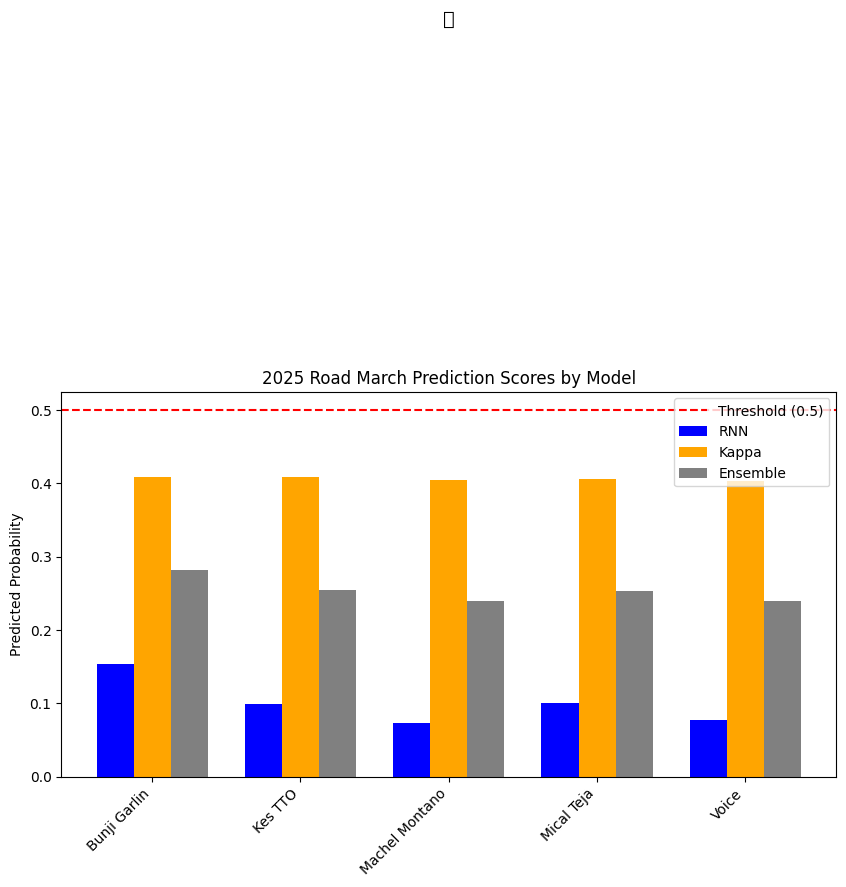

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Create a copy sorted by Performer name for consistency
plot_df = new_songs_df.copy()
plot_df = plot_df.sort_values("Performer").reset_index(drop=True)

# Set positions and bar width
labels = plot_df["Performer"]
x = np.arange(len(labels))  # the label locations
width = 0.25  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot each model's predictions
bars1 = ax.bar(x - width, plot_df["RNN_Prediction"], width, label='RNN', color='blue')
bars2 = ax.bar(x, plot_df["Kappa_Prediction"], width, label='Kappa', color='orange')
bars3 = ax.bar(x + width, plot_df["Ensemble_Prediction"], width, label='Ensemble', color='grey')

# Highlight actual winner (if needed)
for i, winner in enumerate(plot_df["Winner"]):
    if winner == 1:
        ax.text(x[i], 1.02, "🏆", ha='center', va='bottom', fontsize=14)

# Labels and formatting
ax.set_ylabel('Predicted Probability')
ax.set_title('2025 Road March Prediction Scores by Model')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.axhline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
ax.legend()

plt.tight_layout()
plt.show()


In [ ]:
new_songs_df.head(5)

,Year,Performer,Song,Lyrics,Winner,Tempo,Key,Mode,Sentiment,Year_Scaled,Tempo_Scaled,Key_Scaled,Mode_Scaled,RNN_Prediction,Kappa_Prediction,Ensemble_Prediction,Ensemble Prediction
0,2025,Kes TTO,Cocoa Tea,[Verse 1]\nWhen ah feeling under the weather\n...,0,138.3,2,1,0.9819,1.0,0.601050,0.181818,1.0,0.099033,0.408804,0.253918,0.253918
1,2025,Machel Montano,Pardy,We work so hard every week\nWe deserve a pardy...,1,144.8,6,0,0.9655,1.0,0.771654,0.545455,0.0,0.073254,0.404818,0.239036,0.239036
2,2025,Bunji Garlin,Carry It,"Intro\n\nYes I can hear them saying, boy stop ...",0,130.2,5,0,0.9934,1.0,0.388451,0.454545,0.0,0.153981,0.408143,0.281062,0.281062
3,2025,Mical Teja,Energy,[Intro]\nCan you feel the love on a stranger's...,0,133.1,7,1,0.2695,1.0,0.464567,0.636364,1.0,0.100174,0.406089,0.253131,0.253131
4,2025,Voice,Higher,I have it\nA serious problem\nI have it\nA big...,0,123.9,10,1,0.9777,1.0,0.223097,0.909091,1.0,0.076587,0.402642,0.239614,0.239614


array([1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0., 1., 0.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       1., 0., 1., 0., 0.], dtype=float32)

In [ ]:
assert y.shape == rnn_probs.shape == kappa_probs.shape == ensemble_probs.shape

# **RNN + Kappa Meta Learner** (needs fixing and not included in project)

In [ ]:
rnn_train_preds = model.predict([lyrics_array, metadata_array]).flatten()  # shape (63,)
kappa_train_preds = kappa_pipeline.predict(X_2025_final)  # shape (63,)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [ ]:
X_combined = np.column_stack([rnn_train_preds, kappa_train_preds])  # Shape: (63, 2)


In [ ]:
from sklearn.model_selection import train_test_split

# Split the combined prediction features and target labels
X_meta_full, X_test_final, y_meta_full, y_test_final = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Further split for training and validation of the ensemble model
X_train_base, X_val, y_train_base, y_val = train_test_split(
    X_meta_full, y_meta_full, test_size=0.25, random_state=42
)


In [ ]:
model.fit(
    [X_train_base[:, :max_length], X_train_base[:, max_length:]],
    y_train_base,
    epochs=10,
    batch_size=32,
    validation_data=([X_val[:, :max_length], X_val[:, max_length:]], y_val)
)


In [ ]:
X_train_kappa = X_train_base[:, max_length:]  # metadata only
X_val_kappa = X_val[:, max_length:]

kappa_pipeline.fit(X_train_kappa, y_train_base)


Pipeline(steps=[('scaler', MinMaxScaler()),
                ('encoder', KappaEncoder(kappa={0: 1.0, 1: 1.0})),
                ('regressor', KappaRegressor(kappa=1.2))])

In [ ]:
# RNN prediction
rnn_probs_val = model.predict([X_val[:, :max_length], X_val[:, max_length:]])

# Kappa prediction
kappa_probs_val = kappa_pipeline.predict(X_val_kappa)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step


In [ ]:
from sklearn.linear_model import LogisticRegression

# Stack predictions as meta features
X_meta = np.column_stack([rnn_probs_val, kappa_probs_val])
y_meta = y_val

meta_model = LogisticRegression()
meta_model.fit(X_meta, y_meta)


LogisticRegression()

In [ ]:
X_2025_meta = np.column_stack([
    new_songs_df["RNN_Prediction"].values,
    new_songs_df["Kappa_Prediction"].values
])

# Predict probability of winning
new_songs_df["Ensemble_Prediction_Meta"] = meta_model.predict_proba(X_2025_meta)[:, 1]
new_songs_df.sort_values("Ensemble_Prediction_Meta", ascending=False)[["Performer", "Song", "Ensemble_Prediction_Meta"]]


,Performer,Song,Ensemble_Prediction_Meta
0,Kes TTO,Cocoa Tea,0.323876
2,Bunji Garlin,Carry It,0.320844
1,Machel Montano,Pardy,0.317078
4,Voice,Higher,0.312709
3,Mical Teja,Energy,0.312199


Compare Models

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_true, y_pred_probs, model_name="Model"):
    y_pred_binary = (y_pred_probs >= 0.5).astype(int)

    accuracy = accuracy_score(y_true, y_pred_binary)
    precision = precision_score(y_true, y_pred_binary)
    recall = recall_score(y_true, y_pred_binary)
    f1 = f1_score(y_true, y_pred_binary)
    roc_auc = roc_auc_score(y_true, y_pred_probs)

    print(f"\n📊 Evaluation: {model_name}")
    print(f"Accuracy : {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print(f"ROC AUC  : {roc_auc:.4f}")
    return {
        "model": model_name,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": roc_auc
    }


In [ ]:
# RNN-only prediction
rnn_results = evaluate_model(y_val, rnn_probs_val.flatten(), "RNN")

# Kappa-only prediction
kappa_results = evaluate_model(y_val, kappa_probs_val.flatten(), "Kappa")

# Ensemble (weighted average)
alpha = 0.5  # Tune as needed
ensemble_simple = alpha * rnn_probs_val.flatten() + (1 - alpha) * kappa_probs_val.flatten()
ensemble_avg_results = evaluate_model(y_val, ensemble_simple, "RNN + Kappa (Averaged)")

# Meta-learner ensemble prediction
meta_probs_val = meta_model.predict_proba(np.column_stack([rnn_probs_val, kappa_probs_val]))[:, 1]
ensemble_meta_results = evaluate_model(y_val, meta_probs_val, "RNN + Kappa (Meta Learner)")


In [ ]:
# Combine into a summary table
results = [rnn_results, kappa_results, ensemble_avg_results, ensemble_meta_results]
results_df = pd.DataFrame(results)

# Sort by F1 Score
results_df.sort_values("f1", ascending=False)


,model,accuracy,precision,recall,f1,roc_auc
0,RNN,0.916667,1.0,0.75,0.857143,0.9375
2,RNN + Kappa (Averaged),0.916667,1.0,0.75,0.857143,0.9375
3,RNN + Kappa (Meta Learner),0.916667,1.0,0.75,0.857143,0.9375
1,Kappa,0.666667,0.0,0.00,0.000000,0.3125
